In [4]:
import sys
sys.path.append("../")
from helper import Data
from regressors import Regressor

c:\users\sheel\pycharmprojects\adbi\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\sheel\pycharmprojects\adbi\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\sheel\pycharmprojects\adbi\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\sheel\pycharmprojects\adbi\lib\site-packages\tensorflow\python\f

In [50]:
d = Data()

d.fetch_data()
pre_df = d.preprocess_data(d.df_us_cases)
df = d.daily_data(pre_df)
daily_reg = Regressor(pre_df, 7)

In [51]:
from statsmodels.tsa.arima_model import ARIMA
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
import numpy as np
import datetime
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

def LSTM_mod(self, lookback=7, row='Total', num_estimators=10):
    daily_df = self.daily_df.copy()
    scaler = MinMaxScaler()
    train = daily_df[row].tolist()
    train = np.array(train).reshape((-1, 1))
    train = scaler.fit_transform(train)
    train = train.ravel()

    x_train, y_train = [], []
    for i in range(len(train) - lookback - self.forecast_interval + 1):
        x = train[i:i + lookback]
        x_train.append(x)
        y_train.append(train[i + lookback:i + lookback + self.forecast_interval])

    train_pred = []
    for i in range(len(train)-lookback+1):
        train_pred.append(train[i:i+lookback])

    train_pred = np.array(train_pred)
    train_pred = train_pred.reshape((train_pred.shape[0], train_pred.shape[1], 1))

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
    print(x_train.shape)
    model = Sequential()
    model.add(LSTM(50, input_shape=(lookback, 1)))
    # model.add(LSTM(50, activation='relu'))
    # model.add(Dropout(0.2))
    model.add(Dense(self.forecast_interval))

    model.compile(loss='mean_squared_error', optimizer='adam')
    y_hat = []
    for _ in range(num_estimators):
        model.fit(x_train, y_train, epochs=100, verbose=0, shuffle=True)
        x_test = np.array(y_train[-1]).reshape((1, x_train.shape[1], 1))
        x_test = np.concatenate([train_pred, x_test])
        y_hat.append(scaler.inverse_transform(model.predict(x_test)))

    y_hat = np.array(y_hat)
    ans = []
    for i in range(num_estimators):
        ans.append(y_hat[i, 0:y_hat.shape[1]:lookback].ravel())
    ans = np.array(ans)
    print(ans.shape)
    low, high = [], []
    pred = []
    for i in range(ans.shape[1]):
        low.append(max(ans[:, i].min(), 0))
        high.append(ans[:, i].max())
        pred.append(max(ans[:, i].mean(), 0))


    forecasted_days = self.generate_dates(daily_df.index[-1], self.forecast_interval)
    preds = pd.DataFrame(data=pred, columns=["forecast"],
                         index=daily_df.index[lookback+(train_pred.shape[0])%lookback-1:].union(forecasted_days))
    interval_low = pd.DataFrame(data=low, columns=["interval_low"], index=daily_df.index[lookback+(train_pred.shape[0])%lookback-1:].union(forecasted_days))
    interval_high = pd.DataFrame(data=high, columns=["interval_high"], index=daily_df.index[lookback+(train_pred.shape[0])%lookback-1:].union(forecasted_days))

    daily_df = pd.concat([daily_df, preds, interval_low, interval_high], axis=1)
    return daily_df, model

In [52]:
xg_daily_data, lstm = LSTM_mod(daily_reg)

(166, 7, 1)
(10, 175)


In [53]:
lstm

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline
def LSTM_rep(self, model, lookback=7, row='Total', num_estimators=10):
    daily_df = self.daily_df.copy()
    scaler = MinMaxScaler()
    train = daily_df[row].tolist()
    train = np.array(train).reshape((-1, 1))
    train = scaler.fit_transform(train)
    train = train.ravel()

    x_train, y_train = [], []
    for i in range(len(train) - lookback - 7 + 1):
        x = train[i:i + lookback]
        x_train.append(x)
        y_train.append(train[i + lookback:i + lookback + 7])

    train_pred = []
    for i in range(len(train)-lookback+1):
        train_pred.append(train[i:i+lookback])

    train_pred = np.array(train_pred)
    train_pred = train_pred.reshape((train_pred.shape[0], train_pred.shape[1], 1))

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))

    arr = scaler.inverse_transform(model.predict(x_train))
#     arr = arr.ravel()
#     print(arr)
    print(np.diff(arr))
    plt.plot(np.diff(arr))

[[  30.853241   51.519638   47.01088    73.08882    85.05304    88.98938 ]
 [  30.853241   51.519638   47.01088    73.08882    85.05304    88.98938 ]
 [  30.853241   51.519638   47.01088    73.08882    85.05304    88.98938 ]
 [  30.853241   51.519638   47.01088    73.08882    85.05304    88.98938 ]
 [  30.853241   51.519638   47.01088    73.08882    85.05304    88.98938 ]
 [  30.853241   51.519638   47.01088    73.08882    85.05304    88.98938 ]
 [  30.853241   51.519638   47.01088    73.08882    85.05304    88.98938 ]
 [  30.853241   51.519638   47.01088    73.08882    85.05304    88.98938 ]
 [  30.853241   51.519638   47.01088    73.08882    85.05304    88.98938 ]
 [  30.853241   51.519638   47.01088    73.08882    85.05304    88.98938 ]
 [  30.853241   51.519638   47.01088    73.08882    85.05304    88.98938 ]
 [  30.853241   51.519638   47.01088    73.08882    85.05304    88.98938 ]
 [  30.853241   51.519638   47.01088    73.08882    85.05304    88.98938 ]
 [  30.853241   51.519638

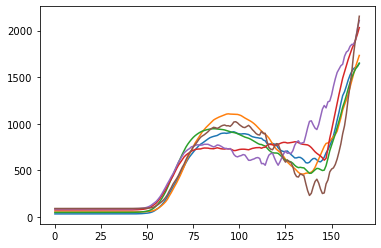

In [66]:
LSTM_rep(daily_reg, lstm, row="North Carolina")

In [81]:
temp = df["Total"]
temp.argmax()

c:\users\sheel\pycharmprojects\adbi\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  


Timestamp('2020-07-16 00:00:00')

In [89]:
temp.dropna()

2020-01-23        0.0
2020-01-24        1.0
2020-01-25        0.0
2020-01-26        3.0
2020-01-27        0.0
               ...   
2020-07-14    67417.0
2020-07-15    67328.0
2020-07-16    77255.0
2020-07-17    71558.0
2020-07-18    63698.0
Name: Total, Length: 178, dtype: float64